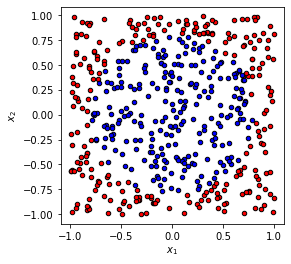

In [1]:
import pennylane as qml
import pandas as pd
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer
import matplotlib.pyplot as plt



np.random.seed(40)

def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):

    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

In [2]:
def density_matrix(state):

    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

In [3]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y):

    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
        
    return qml.expval(qml.Hermitian(y, wires=[0]))


In [4]:
def cost(params, x, y, state_labels=None):
    
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [5]:
def test(params, x, y, state_labels=None):

    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):

    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):

    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [7]:
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))

num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

params = np.random.uniform(size=(num_layers, 3))

opt = GradientDescentOptimizer(learning_rate)


predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.387770 | Train accuracy: 0.460000 | Test Accuracy: 0.418000
Epoch:  1 | Loss: 0.151819 | Train accuracy: 0.780000 | Test accuracy: 0.692500
Epoch:  2 | Loss: 0.115869 | Train accuracy: 0.865000 | Test accuracy: 0.780000
Epoch:  3 | Loss: 0.106784 | Train accuracy: 0.860000 | Test accuracy: 0.776500
Epoch:  4 | Loss: 0.102924 | Train accuracy: 0.870000 | Test accuracy: 0.785500
Epoch:  5 | Loss: 0.100523 | Train accuracy: 0.870000 | Test accuracy: 0.794000
Epoch:  6 | Loss: 0.098761 | Train accuracy: 0.880000 | Test accuracy: 0.799000
Epoch:  7 | Loss: 0.097386 | Train accuracy: 0.885000 | Test accuracy: 0.803500
Epoch:  8 | Loss: 0.096279 | Train accuracy: 0.885000 | Test accuracy: 0.808500
Epoch:  9 | Loss: 0.095369 | Train accuracy: 0.895000 | Test accuracy: 0.812500
Epoch: 10 | Loss: 0.094609 | Train accuracy: 0.895000 | Test accuracy: 0.815500


Cost: 0.094609 | Train accuracy 0.895000 | Test Accuracy : 0.815500
Learned weights
Layer 0: [ 0.54009221  0.93696857 -0.12226159]
Layer 1: [0.00722179 1.15020372 0.13703388]
Layer 2: [0.21208015 0.94783428 0.0125572 ]


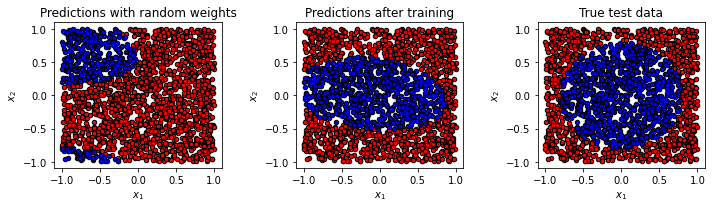

In [8]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])


axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

Source:

[PennyLane Tutorial: Data-reuploading classifier](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html)